<hr style="color:green" />
<h1 style="color:green">COSC2673 Assignment 2: Image Classification for Cancerous Cells</h1>
<h2 style="color:green">File 26: CNN with more complex convolutions and more complex Classifier Network Layers</h2>
<hr style="color:green" />

<p>
<strong>NOTE:</strong> No need to do this one. CNN05, with more classifier layers, did not perform as well as CNN03, so seems like there is no point to making more complex NN layers
</p>

<p>
After Analysis in File 22, CNNs with 3 layer and 2 layer classifiers were experimented with, with good results. But overfitting in these is not the primary concern, first look to improve accuracy
</p>
<p>
Create a custom, simple CNN structure appropriate to the 27x27 pixel image size, this time with a more complex CNN architecture. This may include more complexity in the Convolution Layers or more complexity in the NN layers
</p>

<p>
This notebook initially only considers added complexity to both the convolution layers and the NN layers. Previous experiments had a slight improvement with no early stopping, however, for the improvement in training time, use early stopping. Reduced Early Stopping back to 2
</p>

In [1]:
import pandas as pd
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.utils.data
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image


c:\Users\nelso\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\nelso\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\nelso\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Configure this script as to whether it runs on Google Colab, or locally

In [2]:
# When on Google Colab, running full training, change both to true. Locally, advised set both to false
isGoogleColab = False
useFullData = False

In [3]:
# In local, the base directory is the current directory
baseDirectory = "./"

if isGoogleColab:
    from google.colab import drive
    
    # If this is running on Google colab, assume the notebook runs in a "COSC2673" folder, which also contains the data files 
    # in a subfolder called "image_classification_data"
    drive.mount("/content/drive")
    !ls /content/drive/'My Drive'/COSC2673/

    # Import the directory so that custom python libraries can be imported
    import sys
    sys.path.append("/content/drive/MyDrive/COSC2673/")

    # Set the base directory to the Google Drive specific folder
    baseDirectory = "/content/drive/MyDrive/COSC2673/"

Import the custom python files that contain reusable code

In [4]:
import data_basic_utility as dbutil
import graphing_utility as graphutil
import statistics_utility as statsutil

import a2_utility as a2util
import pytorch_utility as ptutil
from pytorch_utility import CancerBinaryDataset
from pytorch_utility import CancerCellTypeDataset


# randomSeed = dbutil.get_random_seed()
randomSeed = 266305
print("Random Seed: " + str(randomSeed))

Random Seed: 266305


In [5]:
# this file should have previously been created in the root directory
dfImages = pd.read_csv(baseDirectory + "images_main.csv")

In [6]:
# Get The training Split and the Validation Split
dfImagesTrain = dfImages[dfImages["trainValTest"] == 0].reset_index()
dfImagesVal = dfImages[dfImages["trainValTest"] == 1].reset_index()
dfImagesTest = dfImages[dfImages["trainValTest"] == 2].reset_index()

print(dfImagesTrain.shape)
print(dfImagesVal.shape)
print(dfImagesTest.shape)

dfImagesTrain.head()

(7837, 5)
(1031, 5)
(1028, 5)


,index,ImageName,isCancerous,cellType,trainValTest
0,0,./Image_classification_data/patch_images\1.png,0,0,0
1,1,./Image_classification_data/patch_images\10.png,0,0,0
2,3,./Image_classification_data/patch_images\1000.png,1,2,0
3,4,./Image_classification_data/patch_images\10000...,0,1,0
4,5,./Image_classification_data/patch_images\10001...,0,1,0


Note: The definition of the Custom Datasets for both the isCancerous data and the Cell Type data are defined in the pytorch_utility.py file.

Also, rather than loading all the training images and calculating the mean and standard deviation values in here, that was run separately in file 05a.PyTorchGetMeanAndStd.ipynb

Here we can just define the values to use, which shouldn't change unless the data is reloaded and a new train/validation/test split is generated

In [7]:
train_mean, train_std = ptutil.getTrainMeanAndStdTensors()
print(train_mean)
print(train_std)

tensor([0.8035, 0.5909, 0.7640])
tensor([0.1246, 0.1947, 0.1714])


In [8]:
# Create a tranform operation that also normalizes the images according to the mean and standard deviations of the images
transform_normalize = transforms.Compose(
    [transforms.ToPILImage(),
    transforms.ToTensor(), 
    transforms.Normalize(train_mean, train_std)])


In [9]:
cancerous_training_data = None

# Create a custom Dataset for the training and validation data
if useFullData:
    cancerous_training_data = CancerBinaryDataset(isGoogleColab, dfImagesTrain, baseDirectory, transform=transform_normalize)
else:
    # For testing in a small dataset
    dfImagesTrainTest = dfImagesTrain.iloc[range(1000), :].reset_index()
    cancerous_training_data = CancerBinaryDataset(isGoogleColab, dfImagesTrainTest, baseDirectory, transform=transform_normalize, target_transform=None)

cancerous_validation_data = CancerBinaryDataset(isGoogleColab, dfImagesVal, baseDirectory, transform=transform_normalize, target_transform=None)
cancerous_test_data = CancerBinaryDataset(isGoogleColab, dfImagesTest, baseDirectory, transform=transform_normalize, target_transform=None)

# Create data loaders
cancerous_train_dataloader = DataLoader(cancerous_training_data, batch_size=32, shuffle=True, num_workers=2)
cancerous_val_dataloader = DataLoader(cancerous_validation_data, batch_size=32, shuffle=True, num_workers=2)
cancerous_test_dataloader = DataLoader(cancerous_test_data, batch_size=32, shuffle=True, num_workers=2)

# Early Stopping

Using the basic model (class), refactor the code such that the test and validation predictions are made at the end of each epoch and the loss difference between training error and validation error are calculated. Use the F1 Score as the metric

Also implement a "Patience" level, where the patience is the number of consecutive epochs that can occur with no improvement in loss before the process is stopped early.

In [10]:
# Create a class for the Neural Network
class PT_CNN_IsCancerous(nn.Module):

    # In the constructor, initialize the layers to use
    def __init__(self):
        super(PT_CNN_IsCancerous, self).__init__()

        # first, define the subsampling methods. Though they are used multiple times, these are the
        # operations, so only need to be defined once
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # define the Activation methods to use
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

        # define the convolution layers

        # input should be 27x27x3. Apply a 5x5 filter but add a zero-padding layer, 
        # therefore, output should be 24x24x48 (channels aka feature maps)
        # Also, increase the number of features 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=48, kernel_size=5, stride=1, padding=1)
        # There will be a Relu
        # Then a MaxPool of 2x2, halving the dimensions per feature map
        # So input is 12x12x48. Apply a 3x3 filter, also include padding=1, as this is already quite small, and lets consider the edges
        self.conv2 = nn.Conv2d(in_channels=48, out_channels=96, kernel_size=3, stride=1, padding=1)    
        # There will be a Relu        
        # So input is 12x12x96. Apply a 3x3 filter, also include padding=1, as this is already quite small, and lets consider the edges
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=192, kernel_size=3, stride=1, padding=1)
        # Then a MaxPool of 2x2, halving the dimensions per feature map
        
        # define the fully connected neural layers
        self.fc1 = nn.Linear(192 * 6 * 6, 6912)
        self.fc2 = nn.Linear(6912, 4608)
        self.fc3 = nn.Linear(4608, 2304)
        self.fc4 = nn.Linear(2304, 2)

    # Create the forward function, which is used in training
    def forward(self, x):

        # print("Init Shape: " + str(x.shape))

        # Process the first 2 convolution layers, applying maxpooling
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)

        # Then process the remaining convolution layers without any pooling
        x = self.relu(self.conv2(x))        
        x = self.relu(self.conv3(x))

        # Then apply a max pool and average pool on the result
        x = self.maxpool(x)

        # Flatten: This should convert to tensors that are acceptable for the input into the NN 3 layers
        x = x.view(x.size(0), 192 * 6 * 6)

        # Now process the 3 layers of the Fully Connected NN
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))        
        # x = self.relu(self.fc3(x))        
        # x = self.fc3(x)        

        # return the result
        return x


Now train the Fully Connected Neural Network Model.

During training, we will use the following:
- Softmax Cross Entropy Loss as our Loss function. This is a good Loss function that basically converts scores for each class into probabilities
- The Adam Optimizer, which is a version of Gradient Descent
- Initially, just 10 epochs

Create a function to predict

In [11]:
def predictCancerousOnDataSetF1(net, setName, dataloader, printResult=True, printFullResults=False):
    correct, total = 0,  0
    predictions = []

    y_cancerous = []
    y_pred_cancerous = []

    # Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        # Loop through the batch, build the lists of the raw label and prediction values
        for j in range(len(labels)):
            y_cancerous.append(labels[j].item())
            y_pred_cancerous.append(predicted[j].item())

        predictions.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    f1Score = f1_score(y_cancerous, y_pred_cancerous)

    if printFullResults:
        print(setName + ":")        
        print('Confusion matrix: \n')
        print(confusion_matrix(y_cancerous, y_pred_cancerous))
        print("\n- Accuracy Score: " + str(accuracy_score(y_cancerous, y_pred_cancerous)))
        print("- Precision Score: " + str(precision_score(y_cancerous, y_pred_cancerous)))
        print("- Recall Score: " + str(recall_score(y_cancerous, y_pred_cancerous)))
        print("- F1 Score: " + str(f1Score))
    elif printResult:
        print("- " + setName + " F1: " + str(f1Score))        

    return f1Score, y_cancerous, y_pred_cancerous

In [12]:
# set the Learning Rate to use
learning_rate = 0.0001
maxEpochs = 15
patience = 3
disableEarlyStopping = False
criterion = nn.CrossEntropyLoss()

# Use this for L2 Regularization
# net = PT_NN_IsCancerous()
# optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0001)

# Use this for dropouts
net = PT_CNN_IsCancerous()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

bestErrorDiff = 99999
concurrentNonImproves = 0
currentEpoch = 0

bestValF1 = -1
lstEpochs = []
lstTrainF1s = []
lstValF1s = []
for epoch in range(maxEpochs):
    print("Starting Epoch " + str(epoch) + "...")
    currentEpoch = epoch

    # Set the Neural Network into training mode
    net.train()

    # Train through this epoch
    for i, data in enumerate(cancerous_train_dataloader, 0):
        # Get the inputs
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Perform Forward and Backward propagation then optimize the weights
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Set the Neural Network into evaluation (test) mode, so we can evaluate both training and validation error
    net.eval()        
    trainingF1, y_train_cancerous, y_train_pred_cancerous = predictCancerousOnDataSetF1(net, "Training", cancerous_train_dataloader, True, False)
    validationF1, y_val_cancerous, y_val_pred_cancerous = predictCancerousOnDataSetF1(net, "Validation", cancerous_val_dataloader, True, False)

    errorDiff = trainingF1 - validationF1
    print("- F1 Difference: " + str(errorDiff))

    lstEpochs.append(epoch)
    lstTrainF1s.append(trainingF1)
    lstValF1s.append(validationF1)

    if epoch > 0 and (validationF1 - bestValF1 > 0.01):        
        # There is at least percentage point improvement in the validation F1, count this as a 
        # good iteration, regardless of the error difference
        print("- IsGoodStep")
        concurrentNonImproves = 0
        if errorDiff > 0 and errorDiff < bestErrorDiff:  
            bestErrorDiff = errorDiff        
    elif errorDiff < bestErrorDiff:        
        # This epoch is an improvement on the last, so we will continue. the concurrent non improve counts reset for the patience
        print("- IsBetter: " + str(errorDiff) + " : " + str(bestErrorDiff))        
        concurrentNonImproves = 0
        if errorDiff > 0:
            bestErrorDiff = errorDiff
    else:
        # This epoch has the same or worse performance than the last. Check if we have reached the patience, if so, then stop early
        print("- IsNotBetter: " + str(errorDiff) + " : " + str(bestErrorDiff))        
        concurrentNonImproves += 1
        if disableEarlyStopping == False:
            if concurrentNonImproves >= patience:
                print("Early Stopping occurred at Epoch " + str(epoch))
                break

    # update the val F1 score from the previous epoch if it's the best
    if validationF1 > bestValF1:
        bestValF1 = validationF1


    

Starting Epoch 0...
- Training F1: 0.8436018957345971
- Validation F1: 0.863905325443787
- F1 Difference: -0.020303429709189857
- IsBetter: -0.020303429709189857 : 99999
Starting Epoch 1...
- Training F1: 0.8221574344023324
- Validation F1: 0.8392370572207084
- F1 Difference: -0.01707962281837605
- IsBetter: -0.01707962281837605 : 99999
Starting Epoch 2...
- Training F1: 0.8850174216027874
- Validation F1: 0.8871224165341813
- F1 Difference: -0.002104994931393933
- IsGoodStep
Starting Epoch 3...
- Training F1: 0.9092465753424657
- Validation F1: 0.8944099378881988
- F1 Difference: 0.014836637454266888
- IsBetter: 0.014836637454266888 : 99999
Starting Epoch 4...
- Training F1: 0.9109414758269719
- Validation F1: 0.8899224806201551
- F1 Difference: 0.021018995206816826
- IsNotBetter: 0.021018995206816826 : 0.014836637454266888
Starting Epoch 5...
- Training F1: 0.9183673469387754
- Validation F1: 0.8945342571208621
- F1 Difference: 0.023833089817913322
- IsNotBetter: 0.023833089817913322

Look at the training and validation loss plot to track how the model improved during epochs

<module 'matplotlib.pyplot' from 'C:\\Users\\nelso\\AppData\\Roaming\\Python\\Python39\\site-packages\\matplotlib\\pyplot.py'>

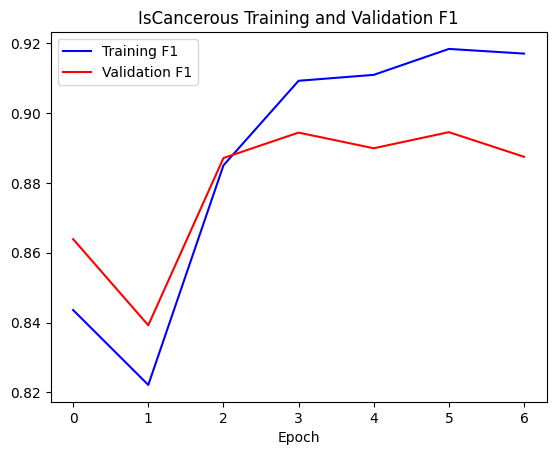

In [13]:
dfLoss = pd.DataFrame({ 'epoch': lstEpochs, 'train': lstTrainF1s, 'validation': lstValF1s })
graphutil.graphBasicTwoSeries(dfLoss, "epoch", "train", "validation", "IsCancerous Training and Validation F1", 
        "Epoch", "Training F1", "Validation F1")

Training Time in Nelson's Local Environment on the full data takes a very long time, stopped after 100 minutes. This will need to be done in Colab.

First, Predict on the training data so that we can find the training error.

In [14]:
# Use the final NN model to predict on the training data
trainingF1, y_train_cancerous, y_train_pred_cancerous = predictCancerousOnDataSetF1(net, "Training", cancerous_train_dataloader, True, True)

Training:
Confusion matrix: 

[[380  46]
 [ 49 525]]

- Accuracy Score: 0.905
- Precision Score: 0.9194395796847635
- Recall Score: 0.9146341463414634
- F1 Score: 0.9170305676855895


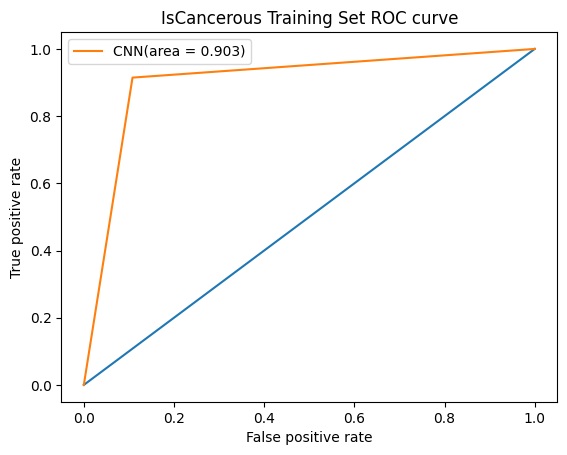

ROC (Area): 0.9033264628420932


0.9033264628420932

In [15]:
a2util.getClassificationROC("IsCancerous", "Training", y_train_cancerous, y_train_pred_cancerous)

Now Predict according to the Validation data and evaluate. While looping through here, we will need to get out the Labels from the data loader, because the order of predictions in the batches do not match the order of the original Target values in the dataset (because we turned Shuffle on)

In [16]:
testF1, y_test_cancerous, y_test_pred_cancerous = predictCancerousOnDataSetF1(net, "Test", cancerous_test_dataloader, True, True)

Test:
Confusion matrix: 

[[330  75]
 [ 64 559]]

- Accuracy Score: 0.8647859922178989
- Precision Score: 0.8817034700315457
- Recall Score: 0.8972712680577849
- F1 Score: 0.8894192521877485


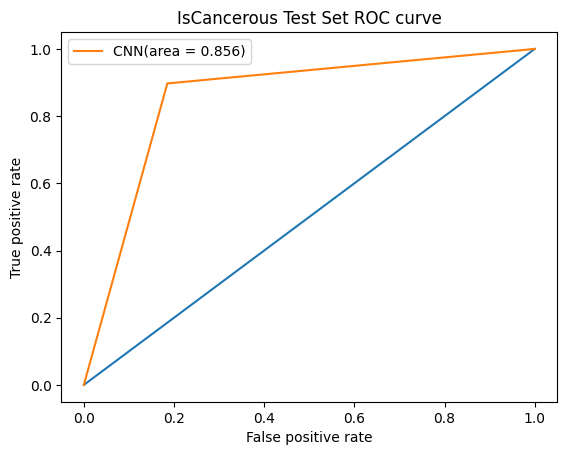

ROC (Area): 0.8560430414363


0.8560430414363

In [17]:
a2util.getClassificationROC("IsCancerous", "Test", y_test_cancerous, y_test_pred_cancerous, 2)

Now also train a model for CellType Predictions

In [18]:
celltype_training_data = None

# Create a custom Dataset for the training and validation data
if useFullData:
    celltype_training_data = CancerCellTypeDataset(isGoogleColab, dfImagesTrain, baseDirectory, transform=transform_normalize)
else:
    # For testing in a small dataset
    dfImagesTrainTest = dfImagesTrain.iloc[range(1000), :].reset_index()
    celltype_training_data = CancerCellTypeDataset(isGoogleColab, dfImagesTrainTest, baseDirectory, transform=transform_normalize, target_transform=None)

celltype_validation_data = CancerCellTypeDataset(isGoogleColab, dfImagesVal, baseDirectory, transform=transform_normalize)
celltype_test_data = CancerCellTypeDataset(isGoogleColab, dfImagesTest, baseDirectory, transform=transform_normalize)

# Create data loaders
celltype_train_dataloader = DataLoader(celltype_training_data, batch_size=32, shuffle=True, num_workers=2)
celltype_val_dataloader = DataLoader(celltype_validation_data, batch_size=32, shuffle=True, num_workers=2)
celltype_test_dataloader = DataLoader(celltype_test_data, batch_size=32, shuffle=True, num_workers=2)

Create a class for the Cell Type Neural Network model. The structure of the class will be fundamentally the same, only the model will need to output 4 classes

In [19]:
# Create a class for the Neural Network
class PT_CNN_CellType(nn.Module):

    # In the constructor, initialize the layers to use
    def __init__(self):
        super(PT_CNN_CellType, self).__init__()

        # first, define the subsampling methods. Though they are used multiple times, these are the
        # operations, so only need to be defined once
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # define the Activation methods to use
        self.relu = nn.ReLU(inplace=True)
        self.softmax = nn.Softmax(dim=1)

        # define the convolution layers

        # input should be 27x27x3. Apply a 5x5 filter but add a zero-padding layer, 
        # therefore, output should be 24x24x48 (channels aka feature maps)
        # Also, increase the number of features 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=48, kernel_size=5, stride=1, padding=1)
        # There will be a Relu
        # Then a MaxPool of 2x2, halving the dimensions per feature map
        # So input is 12x12x48. Apply a 3x3 filter, also include padding=1, as this is already quite small, and lets consider the edges
        self.conv2 = nn.Conv2d(in_channels=48, out_channels=96, kernel_size=3, stride=1, padding=1)    
        # There will be a Relu        
        # So input is 12x12x96. Apply a 3x3 filter, also include padding=1, as this is already quite small, and lets consider the edges
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=192, kernel_size=3, stride=1, padding=1)
        # Then a MaxPool of 2x2, halving the dimensions per feature map
        
        # define the fully connected neural layers
        self.fc1 = nn.Linear(192 * 6 * 6, 6912)
        self.fc2 = nn.Linear(6912, 4608)
        self.fc3 = nn.Linear(4608, 2304)
        self.fc4 = nn.Linear(2304, 2)

    # Create the forward function, which is used in training
    def forward(self, x):

        # print("Init Shape: " + str(x.shape))

        # Process the first 2 convolution layers, applying maxpooling
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)

        # Then process the remaining convolution layers without any pooling
        x = self.relu(self.conv2(x))        
        x = self.relu(self.conv3(x))

        # Then apply a max pool and average pool on the result
        x = self.maxpool(x)
        #x = self.avgpool(x)

        # Flatten: This should convert to tensors that are acceptable for the input into the NN 3 layers
        x = x.view(x.size(0), 192 * 6 * 6)

        # Now process the 3 layers of the Fully Connected NN
        x = self.relu(self.fc1(x))  
        x = self.relu(self.fc2(x))  
        x = self.relu(self.fc3(x))                 
        # x = self.fc3(x)
        # x = self.relu(self.fc3(x))
        x = F.softmax(self.fc4(x), dim=1)        

        # return the result
        return x



Now train the Fully Connected Neural Network Model. Use the same configuration (objective function, optimizer etc) as the Binary Classifier

In [20]:
def predictCellTypeOnDataSetAccuracy(net, setName, dataloader, printResult=True, printFullResults=False):
    correct, total = 0,  0
    predictions = []

    y_celltype = []
    y_pred_celltype = []
    y_pred_celltype_scores = []

    # Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        # Loop through the batch, build the lists of the raw label and prediction values
        for j in range(len(labels)):
            y_celltype.append(labels[j].item())
            y_pred_celltype.append(predicted[j].item())
            y_pred_celltype_scores.append(outputs.data[j].tolist())

        predictions.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = accuracy_score(y_celltype, y_pred_celltype)
    f1Score = f1_score(y_celltype, y_pred_celltype, average="micro")

    if printFullResults:
        print(setName + ":")        
        print('Confusion matrix: \n')
        print(confusion_matrix(y_celltype, y_pred_celltype))
        print("\n- Accuracy Score: " + str(accuracy))
        print("- Precision Score: " + str(precision_score(y_celltype, y_pred_celltype, average="micro")))
        print("- Recall Score: " + str(recall_score(y_celltype, y_pred_celltype, average="micro")))
        print("- F1 Score: " + str(f1Score))
    elif printResult:
        print("- " + setName + " Accuracy: " + str(accuracy))

    return accuracy, y_celltype, y_pred_celltype, y_pred_celltype_scores

In [21]:
# set the Learning Rate to use
learning_rate = 0.0001
maxEpochs = 15
patience = 3
disableEarlyStopping = False
criterion = nn.CrossEntropyLoss()

# Use this for L2 Regularization
# net = PT_NN_IsCancerous()
# optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0001)

# Use this for dropouts
net = PT_CNN_CellType()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

bestErrorDiff = 99999
concurrentNonImproves = 0
currentEpoch = 0

bestValAcc = -1
lstEpochs = []
lstTrainAccs = []
lstValAccs = []
for epoch in range(maxEpochs):
    print("Starting Epoch " + str(epoch) + "...")
    currentEpoch = epoch

    # Set the Neural Network into training mode
    net.train()

    # Train through this epoch
    for i, data in enumerate(celltype_train_dataloader, 0):
        # Get the inputs
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Perform Forward and Backward propagation then optimize the weights
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Set the Neural Network into evaluation (test) mode, so we can evaluate both training and validation error
    net.eval()        
    trainingAccuracy, y_train_celltype, y_train_pred_celltype, y_train_pred_celltype_scores = predictCellTypeOnDataSetAccuracy(
        net, "Training", celltype_train_dataloader, True, False)
    validationAccuracy, y_val_celltype, y_val_pred_celltype, y_val_pred_celltype_scores  = predictCellTypeOnDataSetAccuracy(
        net, "Validation", celltype_val_dataloader, True, False)

    errorDiff = trainingAccuracy - validationAccuracy
    print("- Accuracy Difference: " + str(errorDiff))

    lstEpochs.append(epoch)
    lstTrainAccs.append(trainingAccuracy)
    lstValAccs.append(validationAccuracy)

    if epoch > 0 and (validationAccuracy - bestValAcc > 0.01):        
        # There is at least percentage point improvement in the validation F1, count this as a 
        # good iteration, regardless of the error difference
        print("- IsGoodStep")
        concurrentNonImproves = 0
        if errorDiff > 0 and errorDiff < bestErrorDiff:  
            bestErrorDiff = errorDiff        
    elif errorDiff < bestErrorDiff:        
        # This epoch is an improvement on the last, so we will continue. the concurrent non improve counts reset for the patience
        print("- IsBetter: " + str(errorDiff) + " : " + str(bestErrorDiff))        
        concurrentNonImproves = 0
        if errorDiff > 0:
            bestErrorDiff = errorDiff
    else:
        # This epoch has the same or worse performance than the last. Check if we have reached the patience, if so, then stop early
        print("- IsNotBetter: " + str(errorDiff) + " : " + str(bestErrorDiff))        
        concurrentNonImproves += 1
        if disableEarlyStopping == False:
            if concurrentNonImproves >= patience:
                print("Early Stopping occurred at Epoch " + str(epoch))
                break

    # update the val F1 score from the previous epoch if it's the best
    if validationAccuracy > bestValAcc:
        bestValAcc = validationAccuracy


Starting Epoch 0...


IndexError: Target 2 is out of bounds.

<module 'matplotlib.pyplot' from 'C:\\Users\\nelso\\AppData\\Roaming\\Python\\Python39\\site-packages\\matplotlib\\pyplot.py'>

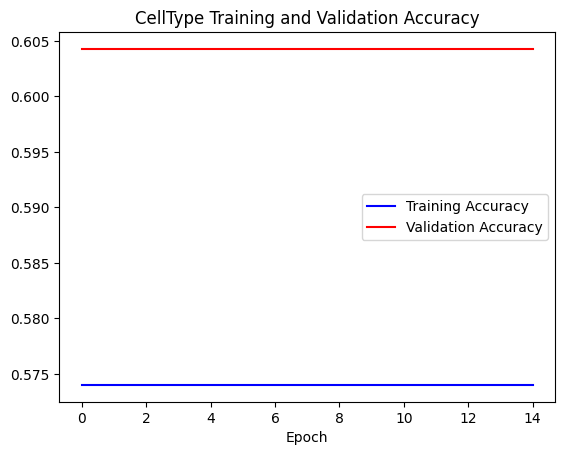

In [ ]:
dfLoss = pd.DataFrame({ 'epoch': lstEpochs, 'train': lstTrainAccs, 'validation': lstValAccs })
graphutil.graphBasicTwoSeries(dfLoss, "epoch", "train", "validation", "CellType Training and Validation Accuracy", 
        "Epoch", "Training Accuracy", "Validation Accuracy")

Predict on the Training Set to get the Training Accuracy and Error

In [ ]:
trainingAcc, y_train_celltype, y_train_pred_celltype, y_train_pred_celltype_scores = predictCellTypeOnDataSetAccuracy(
    net, "Training", celltype_train_dataloader, True, True)

Training:
Confusion matrix: 

[[  0   0 126   0]
 [  0   0 138   0]
 [  0   0 574   0]
 [  0   0 162   0]]

- Accuracy Score: 0.574
- Precision Score: 0.574
- Recall Score: 0.574
- F1 Score: 0.574


In [ ]:
for i in range(5):
    print(y_train_pred_celltype_scores[i])

[5.414594845375664e-38, 3.799893826219918e-36, 1.0, 2.0685077664148827e-34]
[0.0, 9.80908925027372e-44, 1.0, 1.3271697755620342e-41]
[2.802596928649634e-44, 4.138034365151185e-42, 1.0, 4.59621692403147e-40]
[2.802596928649634e-45, 4.974609548353101e-43, 1.0, 5.619206841942516e-41]
[0.0, 0.0, 1.0, 9.949219096706201e-44]


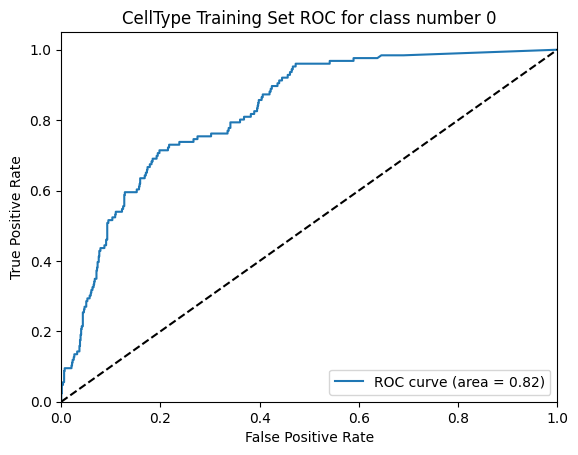

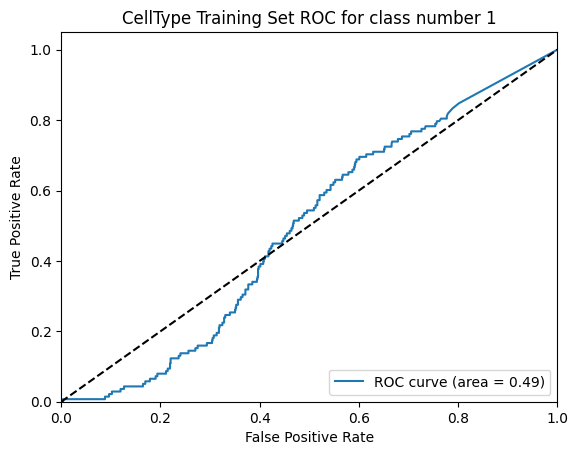

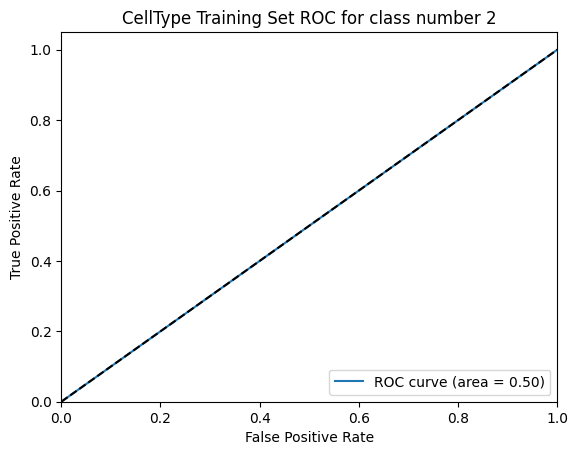

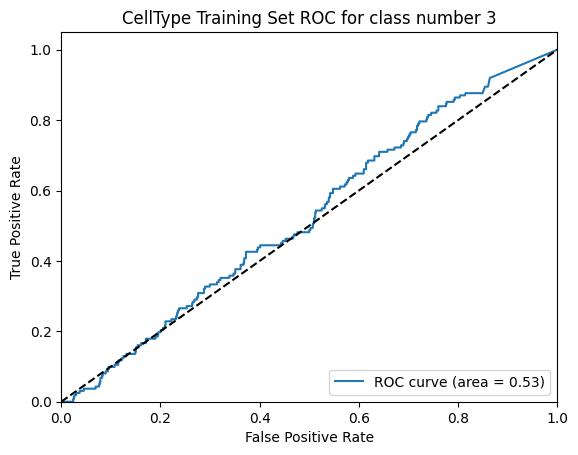

Mean ROC (Area): 0.5852537297424052


0.5852537297424052

In [ ]:
a2util.getClassificationROC("CellType", "Training", y_train_celltype, y_train_pred_celltype, 4, y_train_pred_celltype_scores)

Predict on the Validation data and evaluate the results

In [ ]:
testAccuracy, y_test_celltype, y_test_pred_celltype, y_test_pred_celltype_scores  = predictCellTypeOnDataSetAccuracy(
        net, "Test", celltype_test_dataloader, True, True)


Test:
Confusion matrix: 

[[  0   0 140   0]
 [  0   0 185   0]
 [  0   0 623   0]
 [  0   0  80   0]]

- Accuracy Score: 0.6060311284046692
- Precision Score: 0.6060311284046692
- Recall Score: 0.6060311284046692
- F1 Score: 0.6060311284046692


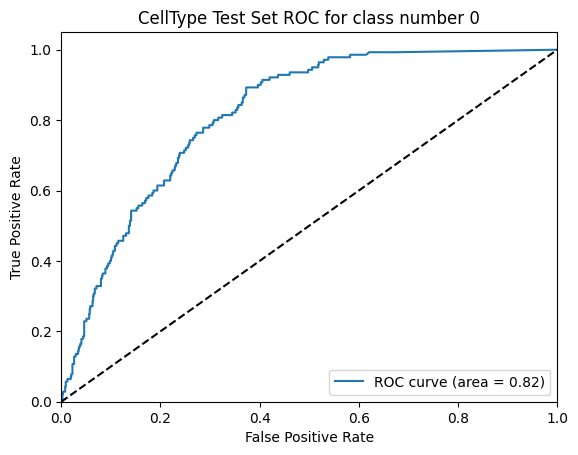

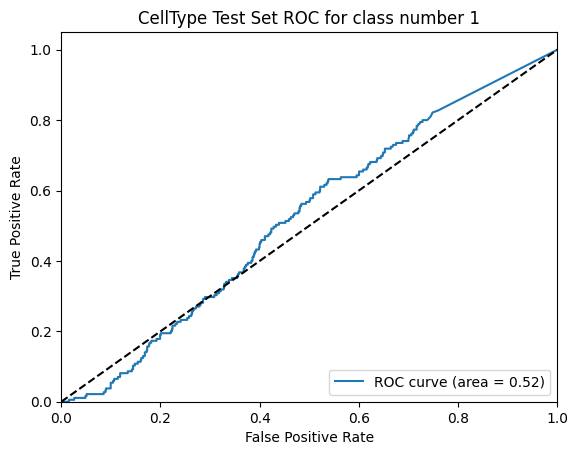

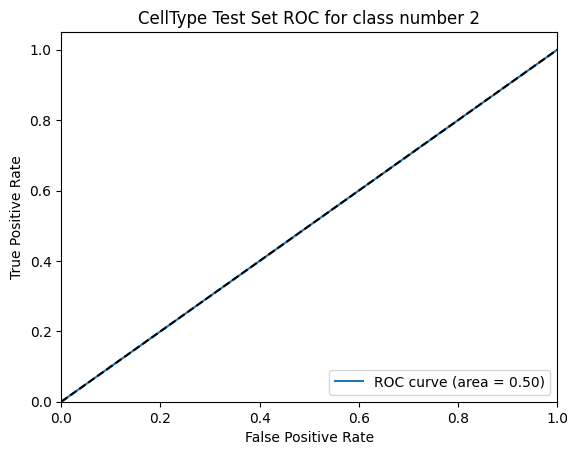

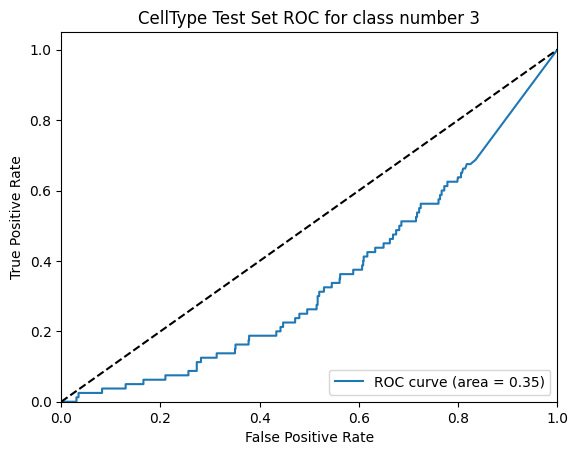

Mean ROC (Area): 0.5477816855112144


0.5477816855112144

In [ ]:
a2util.getClassificationROC("CellType", "Test", y_test_celltype, y_test_pred_celltype, 4, y_test_pred_celltype_scores)

# Results

Append Results for both Binary IsCancerous and Cell Type here

### IsCancerous Results

Basic 01, 3 Layer NN with Dropout - On Colab, Full data - Previous best performing
- Training Accuracy: 0.942
- Training F1: 0.923
- Validation Accuracy: 0.869
- Validation F1: 0.897

CNN01, 3 Layer Classifier Binary with Sigmoid as Final Activation Function
- **Training**
- Accuracy Score: 0.9518948577261708
- Precision Score: 0.9426820475847152
- Recall Score: 0.9230497705612425
- F1 Score: 0.9327626181558766
- **Validation**
- Accuracy Score: 0.8894277400581959
- Precision Score: 0.9178981937602627
- Recall Score: 0.8972712680577849
- F1 Score: 0.9074675324675324

CNN02, 3 Layer Classifier with Early Stopping
- **Training**
- Accuracy Score: 0.9475564629322445
- Precision Score: 0.9328091493924232
- Recall Score: 0.9212848570420049
- F1 Score: 0.927011188066063
- **Test**
- Accuracy Score: 0.8764591439688716
- Precision Score: 0.8936507936507937
- Recall Score: 0.9036918138041734
- F1 Score: 0.8986432561851556


CNN02, 2 Layer Classifier with Early Stopping
- **Training**
- Accuracy Score: 0.9281612862064565
- Precision Score: 0.9235074626865671
- Recall Score: 0.8736321920225909
- F1 Score: 0.8978777435153275
- **Test**
- Accuracy Score: 0.8764591439688716
- Precision Score: 0.9039087947882736
- Recall Score: 0.8908507223113965
- F1 Score: 0.8973322554567501

CNN03, 3 Layer Classifier, more complex Convolutions
- **Training**
- Accuracy Score: 0.9506188592573689
- Precision Score: 0.952292899408284
- Recall Score: 0.908930462407342
- F1 Score: 0.9301065558966949
- **Validation**
- Accuracy Score: 0.8803501945525292
- Precision Score: 0.9222972972972973
- Recall Score: 0.8764044943820225
- F1 Score: 0.8987654320987655

### Cell type Results

Basic 01, 3 Layer NN with Dropout - On Colab, Full data - Previous best performing
- Training Accuracy: 0.844
- Training F1: 0.844
- Validation Accuracy: 0.778
- Validation F1: 0.778

CNN01, 3 Layer Classifier with Softmax as Final Activation Function, no Early Stopping
- **Training**
- Accuracy Score: 0.842414189102973
- Precision Score: 0.842414189102973
- Recall Score: 0.842414189102973
- F1 Score: 0.842414189102973
- **Validation**
- Accuracy Score: 0.7827352085354026
- Precision Score: 0.7827352085354026
- Recall Score: 0.7827352085354026
- F1 Score: 0.7827352085354026

CNN02, 3 Layer Classifier with Early Stopping
- **Training**
- Accuracy Score: 0.8100038279954064
- Precision Score: 0.8100038279954064
- Recall Score: 0.8100038279954064
- F1 Score: 0.8100038279954064
- **Validation**
- Accuracy Score: 0.7957198443579766
- Precision Score: 0.7957198443579766
- Recall Score: 0.7957198443579766
- F1 Score: 0.7957198443579766

CNN02, 2 Layer Classifier with Early Stopping
- **Training**
- Accuracy Score: 0.7962230445323466
- Precision Score: 0.7962230445323466
- Recall Score: 0.7962230445323466
- F1 Score: 0.7962230445323466
- **Test**
- Accuracy Score: 0.7928015564202334
- Precision Score: 0.7928015564202334
- Recall Score: 0.7928015564202334
- F1 Score: 0.7928015564202334


CNN03, 3 Layer Classifier, more complex Convolutions, with Early Stopping
- **Training**
- Accuracy Score: 0.8606609672068394
- Precision Score: 0.8606609672068394
- Recall Score: 0.8606609672068394
- F1 Score: 0.8606609672068394
- **Test**
- Accuracy Score: 0.8103112840466926
- Precision Score: 0.8103112840466926
- Recall Score: 0.8103112840466926
- F1 Score: 0.8103112840466926

<h1>Analysis of Performance and Accuracy</h1>

<h3>Is Cancerous</h3>
<p>
The best performing model after initial CNN experiments, according to F1 Score, is the CNN with 3 Layer Classifier, with no Early stopping. the F1 Score is <strong>0.907</strong>, which is only a 0.01 improvement on the Basic NN 2 Layer model.
</p>
<p>
However, we can see that the difference between the Training F1 and the Test F1 in this CNN is a lot smaller, with the Training F1 being 0.93. This is a situation where we have higher bias but less variance, with higher bias compared to other experiments. Therefore, it may be possible to model with more accuracy to reduce the bias, however, we must be careful not to overfit.
</p>

<h3>Is Cancerous</h3>
<p>
The best performing model after initial CNN experiments, according to Accuracy, is the CNN with 2 Layer Classifier, with Early stopping. the F1 Score is <strong>0.792</strong>, which is a 0.014 improvement on the Basic NN 2 Layer model.
</p>
<p>
However, we can see that the difference between the Training Accuracy and the Test Accuracy in this CNN very small, with the Testing accuracy being <strong>0.796</strong>. This indicates that the model is generalizing very well. However, it appears that this model has a higher bias than other experiments.
</p>

<h3>Conclusion</h3>
<p>
Therefore, for both models, it is worth experimenting on how accuracy can be improved. There are 3 methods that initially should be tried
</p>
<ol>
<li>First, experiment with a more complex CNN model, with additional complexity in the Convolution and the Classifier parts</li>
<li>Addition of more data to train with, specifically the Extra data provided</li>
<li>Data Augmentation</li>
</ol>

